# Plotting FWI for 2022 for ESOTC

<div class="alert alert-block alert-info">
<b>Note:</b> If you're running this notebook on ATOS using ecinteractive, make sure that you started it with at least 16 GB ram memory, otherwise it will crash at some point.
</div>

In this notebook we calculate and plot the diffrence between number of days when FWI>50 in 2022 and mean number in 1991-2022 climatology.  

At the moment reading of the data is hardcoded, as the files are in Chris' scratch directory.  

First import bunch of stuff:

In [198]:
import xarray as xr
import cartopy as cart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import pandas as pd
import datetime as dt
import numpy as np
plt.rcParams.update({'font.size': 25})

In [199]:
fwi = xr.open_mfdataset('/scratch/maca/geff-grib-issue/reg_fwi.nc')


ESOTC regions 

Europe: 25°W–40°E, 34°–72°N
Southwestern Europe: 25°W–15°E, 34°–45°N
Northwestern Europe: 25°W–15°E, 45°–72°N
Southeastern Europe: 15°–40°E, 34°–45°N
Northeastern Europe: 15°–40°E, 45°–72°N
Central Europe: 2°–24°E, 45°–55°N
    
    
    

In [200]:
esotc_regions={'Europe':[-25,40,72,34,0,20],
            'Southwestern-Europe':[-25,15,45,34,0,45],
            'Northwestern-Europe':[-25,15,72,45,0,20],
            'Southeastern-Europe':[15,40,45,34,0,45],
            'Northeastern-Europe':[15,40,72,45,0,20]}

nr=len(esotc_regions)
for key in esotc_regions:
    print(key)

Europe
Southwestern Europe
Northwestern Europe
Southeastern Europe
Northeastern Europe


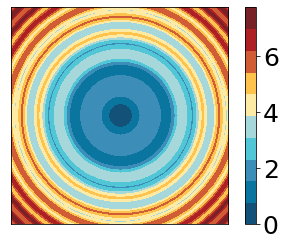

In [201]:
#color test 
cx, cy = np.mgrid[-5:5:0.05, -5:5:0.05]
cz = (np.sqrt(cx**2 + cy**2) + np.sin(cx**2 + cy**2))
redblue = ['#135178', '#0a759f', '#3c8db8', '#51c6d7', '#a6d7db', '#fdeaa5', '#fec34d', '#d15d36', '#ad2124', '#772227']
# Create the custom colormap
my_cmap = (colors.ListedColormap(redblue))
my_cmap.set_over('#772227')
my_cmap.set_under('#135178')

fig, ax = plt.subplots(1,1)
im = ax.imshow(cz, cmap=my_cmap)
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks

Loop over all the ESOTC regions 

Europe
end
Southwestern Europe
end
Northwestern Europe
end
Southeastern Europe
end
Northeastern Europe
end


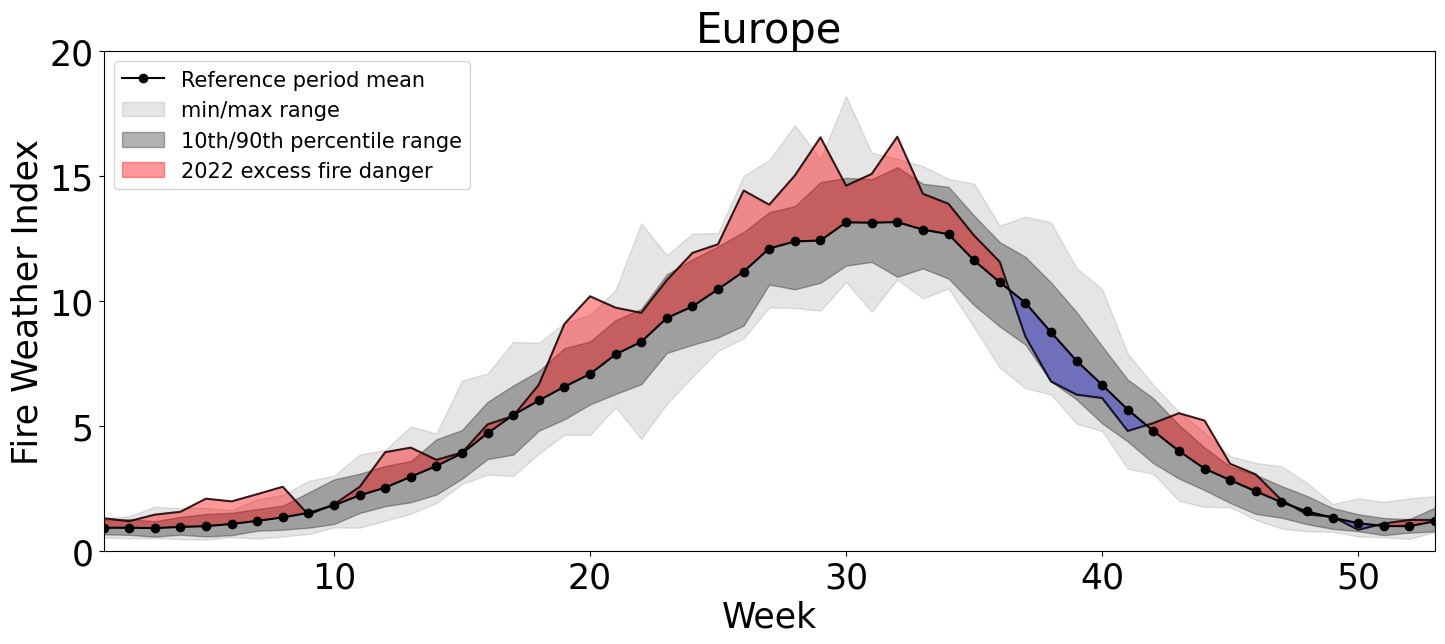

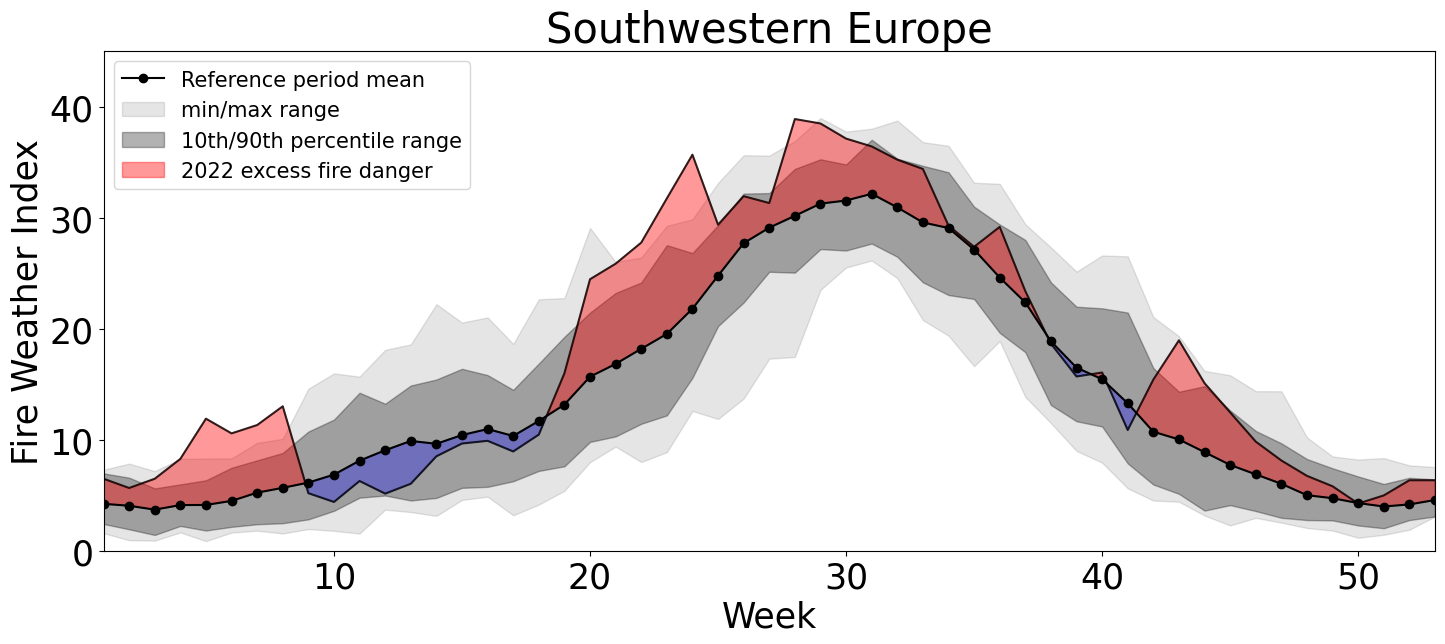

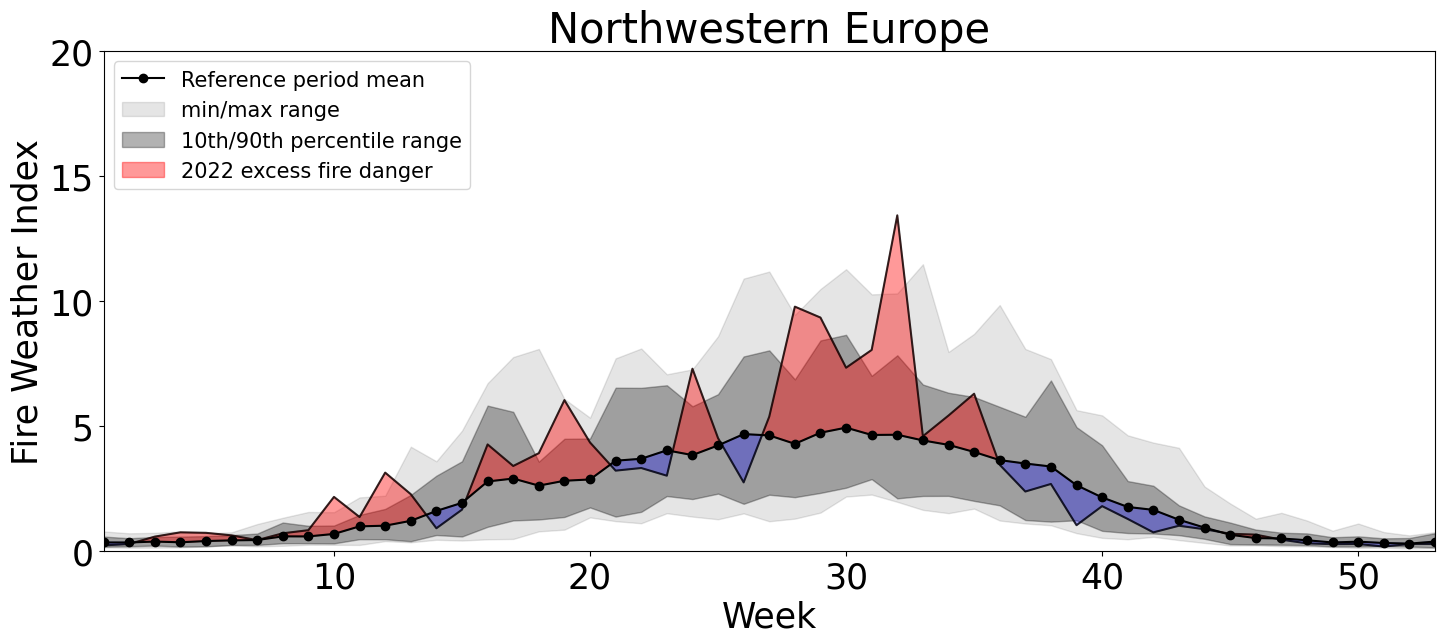

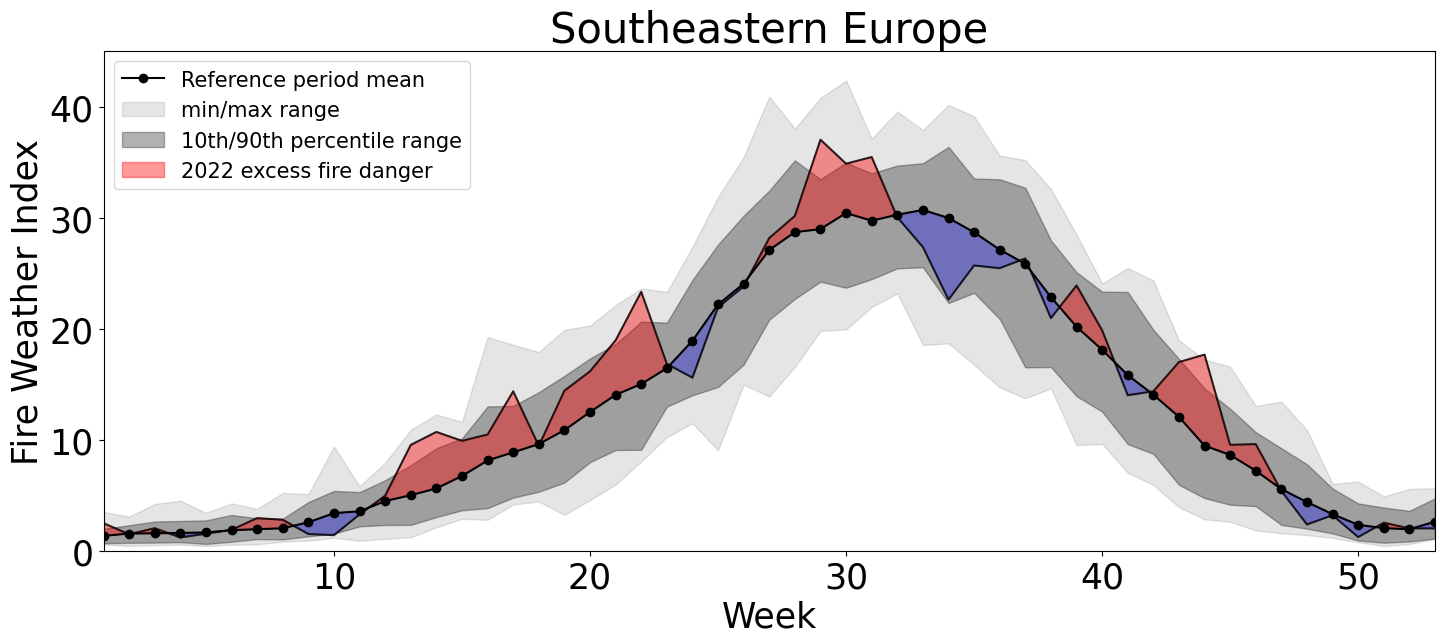

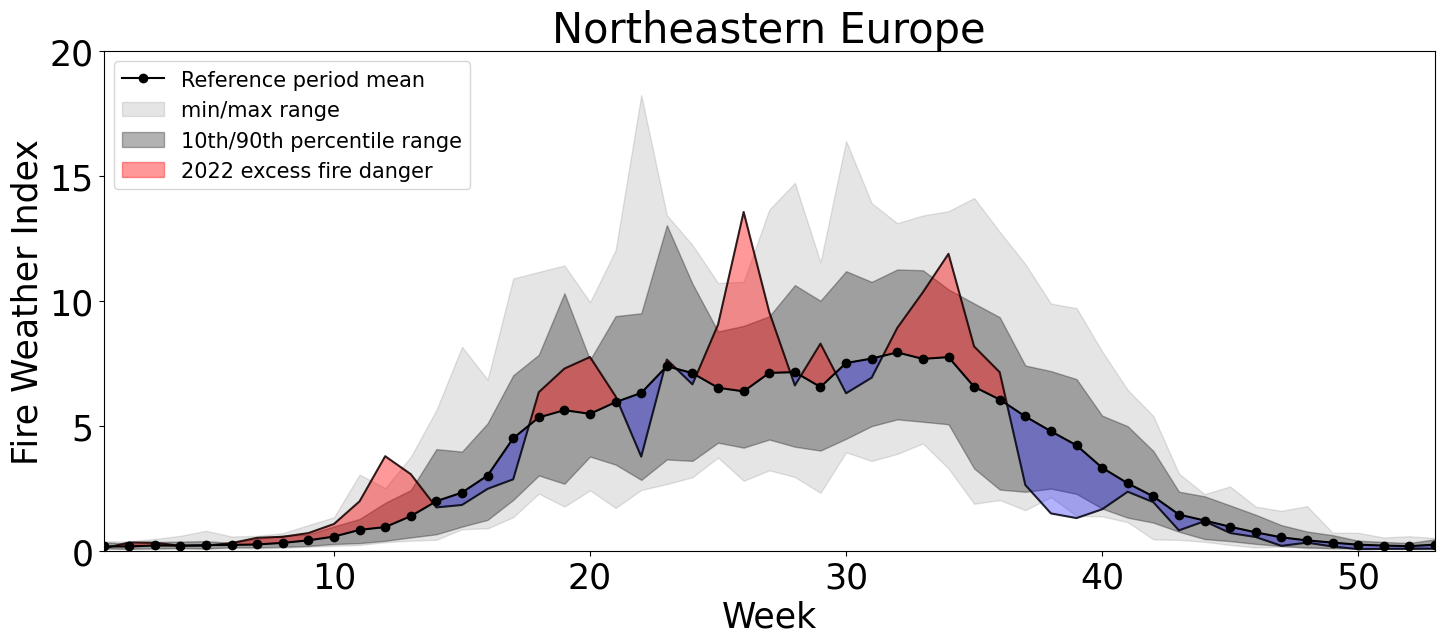

In [209]:
for key in esotc_regions:
    print(key)
    lon1=esotc_regions[key][0]
    lon2=esotc_regions[key][1]
    lat1=esotc_regions[key][2]
    lat2=esotc_regions[key][3]
    cymin=esotc_regions[key][4]
    cymax=esotc_regions[key][5]
    small = fwi.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))
# Clima 
    clim= small.sel(time=slice('1991-01-01','2020-12-31')).mean(dim=['longitude','latitude'])
    weekly_clim= clim.resample(time='W').mean(dim='time')  
    weekly_clim=weekly_clim.chunk({'time':-1})
    w_clim_mean=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).mean().load()
    w_clim_max=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).max().load()
    w_clim_min=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).min().load()
    w_clim_q10=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).quantile(0.1).load()
    w_clim_q90=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).quantile(0.9).load()
# this year 
    ty= small.sel(time=slice('2022-01-01','2022-12-31')).mean(dim=['longitude','latitude'])
    weekly_ty= ty.resample(time='W').mean(dim='time')  
    weekly_ty=weekly_ty.chunk({'time':-1})
    w_ty_mean=weekly_ty.groupby(weekly_ty['time'].dt.isocalendar().week).mean().load()
# variables for plotting 
    x=w_clim_max['week'].values
    xdate = "2022-W26"
    r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    ymean=w_clim_mean.fwinx.values
    ymin=w_clim_min.fwinx.values
    ymax=w_clim_max.fwinx.values
    y10=w_clim_q10.fwinx.values
    y90=w_clim_q90.fwinx.values
    tymean=w_ty_mean.fwinx.values
# this only needed if odd number of weeks 
    tymean=np.append(tymean,tymean[51])
    fig, ax = plt.subplots(1, figsize=(15, 7),dpi=100)
    ax.fill_between(x, ymax, ymin, 
                    color="k", 
                    alpha=0.1, 
                    label='min/max range')
    ax.fill_between(x, y10, y90, 
                    color="k",
                    alpha=0.3, 
                    label='10th/90th percentile range')
    ax.plot(x, ymean, 'o-', 
            color="k", 
            label="Reference period mean")

    ax.fill_between(x, ymean,tymean,
    color="r",
    alpha=0.4,
    where= tymean>= ymean,
    interpolate=True, 
    label="2022 excess fire danger")
 
    ax.fill_between(x, ymean,tymean,
    color="b",
    alpha=0.3,
    where= tymean <= ymean,
    interpolate=True)

    ax.plot(x, tymean, '-', color='black',alpha=0.8)
    ax.legend(loc='upper left',fontsize=15)
    plt.ylim(ymax=cymax,ymin=cymin)  # this line
    plt.xlim(xmax=53,xmin=1)
    plt.title(key)
    ax.set_xlabel('Week')
    ax.set_ylabel('Fire Weather Index')
    plt.tight_layout()
    plt.savefig('/home/nen/scripts/ESOTC/2022/'+key+'_weeklyTS.tiff', format='tiff',facecolor='white')
    print('end')
    
    